<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-3-2.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# NN Heston Model - Market Data Generations

## Purpose of This Notebook

This notebook is a continuation of the practical implementation of the **Volatility Feature Approach (VFA)** for option pricing, as introduced in the lecture *"Deep Learning Derivatives Pricing"* (University of Bologna, 2025). It serves as the **final preparatory step** before training a deep neural network to learn the option pricing function from synthetic data.

Whereas the previous notebook (`lesson-2-2.ipynb`) focused on generating the synthetic option pricing data under a model-driven approach, this notebook focuses on **reshaping and organizing that data** for use in a **model-free learning pipeline** — the core idea behind the VFA.

**Specifically, the notebook performs the following**:

1. **Loading and preprocessing option pricing data**
- Imports CSV datasets of vanilla option prices computed with a model (e.g., Black-Scholes).
- Parses key features such as **time to maturity**, **strike/spot ratio**, and **volatility**.
  
2. **Feature and target construction**
- Builds a feature matrix `X` containing only market-observable variables (like moneyness and volatility).
- Constructs the target variable as the model-generated price (representing the "true" value the network should learn to approximate).

3. **Data splitting**
- Separates the full dataset into:
  - A **training set** with full features and known target prices.
  - A **challenge set** (testing set) with input features only (no target shown to the model).
  - A **target set** (labels corresponding to the challenge set) used only for model evaluation.

4. **(Optional) Data perturbation**
- Adds **Gaussian noise** to option prices to simulate real market imperfections, fostering model robustness.

5. **Data visualization**
- Produces scatter plots and histograms to verify the impact of noise and understand price distributions.

6. **Export to disk**
- Writes the three structured datasets to disk:
  - `full_10000_VFA.csv` (training set with features and prices),
  - `test_10000_VFA.csv` (test features only),
  - `trgt_10000_VFA.csv` (true prices for the test set, not used during model training).


### Role in the VFA Workflow

This notebook marks the transition from **data simulation** to **machine learning model development**:

```plaintext
[Market simulation (MCA)] → [Feature-target restructuring (this notebook)] → [Neural network training (next notebook)]
```

By isolating observable features from model assumptions, the notebook aligns precisely with the **VFA philosophy**: training a model to predict option prices **directly from market data**, without fitting a parametric model.

In [6]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from smt.sampling_methods import LHS
from sklearn.model_selection import train_test_split

## Python Auxiliary Functions

In [7]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

### Latin Hypercube Sampling Function

In [8]:
def lhs_sampling(rand, NUM, bounds=None):

    kw = bounds.keys()

    # builds the array of bounds
    limits = np.empty( shape=(0,2) )
    for k in kw: limits = np.concatenate((limits, [bounds[k]]), axis=0)

    sampling = LHS(xlimits=limits)
    x   = sampling(NUM)

    y = np.where( 2*x[:,0]*x[:,1] < x[:,2]*x[:,2], 1, 0)
    p = (100.*np.sum(y))/NUM
    print("@ %-34s: %s = %6d out of %6d ( %.7f %s)" %("Info", "Feller violations", np.sum(y), NUM, p, "%"))

    return kw, x

### Pricing Functions

The following function prices a European forward-start put option using the Heston stochastic volatility model, a popular choice in finance due to its ability to generate skewed and smile-shaped implied volatility surfaces. It leverages Fourier transform techniques for efficient option valuation (as opposed to finite differences or Monte Carlo methods). The function returns the put price in the forward measure, which is standard in this modeling context (often normalized by the forward price).

In [9]:
# Import Heston model object (analytic characteristic function implementation)
from ptr_lib_1.Heston import Heston
# Import numerical Fourier pricing engine (Carr-Madan style or similar)
from ptr_lib_1.FT_opt import ft_opt

# Define a function that prices a forward-start European put option using the Heston model
def HestonPut(St, Strike, T, kappa, theta, sigma, v0, rho, r, Xc=30):
    """
    Prices a European forward-start put option using the Heston stochastic volatility model.
    The pricing is done via Fourier inversion methods (e.g., Carr-Madan) using characteristic functions.

    Parameters:
    -----------
    St : float
        Current spot price of the underlying asset
    Strike : float
        Strike price of the put option
    T : float
        Time to maturity (in years)
    kappa : float
        Mean reversion speed of the variance process
    theta : float
        Long-run mean variance
    sigma : float
        Volatility of volatility
    v0 : float
        Initial variance (at time zero)
    rho : float
        Correlation between the asset price and variance Brownian motions
    r : float
        Risk-free rate (used to discount and compute forward price)
    Xc : float
        Integration cutoff value for the Fourier transform (default = 30)

    Returns:
    --------
    float
        The Heston-model price of the European put option in forward measure
    """

    # Compute the normalized strike kT in terms of the forward measure:
    # This converts the absolute strike into a discounted strike under the forward numeraire.
    kT = (Strike / St) * math.exp(-r * T)

    # Create a Heston model object with the specified parameters
    hestn = Heston(
        lmbda=kappa,   # Mean reversion speed (also called lambda)
        eta=sigma,     # Vol of vol
        nubar=theta,   # Long-run average variance
        nu_o=v0,       # Initial variance
        rho=rho        # Correlation between asset and variance
    )

    # Compute the option price using the Fourier pricing method
    # Returns a dictionary with keys 'call' and 'put'
    res = ft_opt(hestn, kT, T, Xc)

    # Extract and return the price of the put option
    return res['put']

The function `build_smile` is designed to **generate an implied volatility smile** for a set of strikes, assuming the option prices are given by the **Heston stochastic volatility model**.

In detail:
- It **computes the theoretical price** of a **forward-start European put option** using the Heston model for each strike.
- Then it **inverts the Black-Scholes formula** (using the helper function `impVolFromFwPut`) to **extract the implied volatility** corresponding to that price for each strike.
- The output is a **dictionary mapping strikes to implied volatilities** — effectively reconstructing the **implied volatility smile** implied by the Heston model parameters.

1. **Inputs**:
   - `strikes`: A list or array of strike prices for which to compute implied volatilities.
   - `Fw`: Forward price of the underlying (default 1.0).
   - `T`: Time to maturity (in years, default 1.0).
   - `Kappa, Theta, sgma, Ro, Rho`: Heston model parameters:
     - $ \kappa $ = mean reversion speed of variance,
     - $ \theta $ = long-run mean of variance,
     - $ \sigma $ = volatility of volatility,
     - $ \rho $ = correlation between spot and variance shocks,
     - $ \rho $ (written Ro here) = initial variance.
   - `Xc`: Cut-off for numerical integration in Heston pricing.

2. **Process**:
   - For each strike $ k $ in `strikes`:
     - Compute the **Heston model price** of a forward-start European put option using `HestonPut`.
     - Check that the price is not below intrinsic value (a safeguard).
     - Use `impVolFromFwPut` to **compute the implied volatility** that would correspond to this price under the **Black-Scholes formula**.
     - Store the implied volatility in a dictionary, keyed by the strike.

3. **Output**:
   - A dictionary `vol` where each key is the strike (formatted as `"k=..."`) and each value is the **corresponding implied volatility**.

**Why This is Useful**

In practice, **market data** is typically available **in the form of implied volatilities across strikes**, not raw option prices.  
Thus, if you simulate option prices with a complex model like Heston, you often need to **convert them into implied volatilities** to:
- **Compare to market smiles**,
- **Train machine learning models** (especially under the Volatility Feature Approach),
- **Perform model calibration** against observed implied vol surfaces,
- **Visualize the volatility smile**.

This function allows you to **generate a realistic synthetic volatility smile** derived from Heston parameters, but **expressed in the familiar implied volatility terms** used in trading and modeling.

In [10]:
# Import the function used to extract implied volatility from option price,
# using the Black-Scholes formula for forward-start put options.
from ptr_lib_1.euro_opt import impVolFromFwPut

# Define a function to build the implied volatility smile using the Heston model
def build_smile(strikes=None, Fw=1.0, T=1.0, Kappa=1.0, Theta=1.0, sgma=1.0, Ro=0.0, Rho=0.0, Xc=10):
    """
    Constructs an implied volatility smile by:
      1. Computing Heston model prices for forward-start put options at different strikes
      2. Inverting these prices into implied volatilities using the Black-Scholes formula
    
    Parameters:
    ----------
    strikes : list or array
        Strike prices at which to evaluate the smile
    Fw : float
        Forward price of the underlying asset
    T : float
        Time to maturity (in years)
    Kappa, Theta, sgma, Ro, Rho : floats
        Parameters of the Heston model:
            - Kappa: speed of mean reversion
            - Theta: long-run variance
            - sgma: volatility of volatility
            - Ro: initial variance (v0)
            - Rho: correlation between asset and variance
    Xc : float
        Integration cutoff for the Heston numerical integration method
    
    Returns:
    -------
    vol : dict
        Dictionary mapping strike tags ("k=...") to corresponding Black-Scholes implied volatilities
    """
    
    vol = {}  # Initialize an empty dictionary to store volatilities
    
    # Loop over all strikes to compute implied volatilities
    for k in strikes:
        tag = "k=%5.3f" % k  # Format strike for use as a string key (e.g., "k=0.950")

        # Compute the Heston-model price for a forward-start European put
        fwPut = HestonPut(Fw, k, T, Kappa, Theta, sgma, Ro, Rho, 0.0, Xc)
        
        # Validate the output: the option price cannot be below intrinsic value
        if fwPut < max(k - Fw, 0.0):
            return None  # Exit early if the price is invalid (e.g., due to numerical issues)

        # Compute the implied volatility from the Heston price using Black-Scholes inversion
        vol[tag] = impVolFromFwPut(price=fwPut, T=T, kT=k)
    
    return vol  # Return the full implied volatility smile as a dictionary

# Numpy vectorized version

def build_smile_np(strikes=None, Fw=1.0, T= 1.0, Kappa=1., Theta=1., sgma=1.0, Ro=0.0, Rho=0.0, Xc=10):
    vol = []
    for k in strikes:
        fwPut = HestonPut(Fw, k, T, Kappa, Theta, sgma, Ro, Rho, 0.0, Xc)
        if fwPut < max( k-Fw, 0.0): return None
        vol.append(impVolFromFwPut(price = fwPut, T = T, kT = k))

    return np.array(vol)

1.8749999999999998


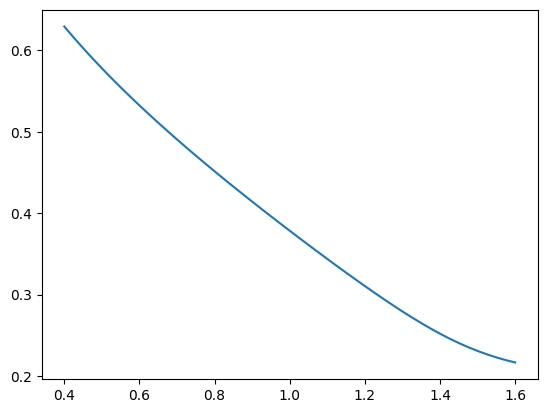

In [12]:
strikes = np.arange(.4, 1.6,.025)
T     = 1.0
theta = 0.4
kappa = 1.5
sigma = 1.5 
rho   = -0.9
ro    = 0.05

feller = sigma*sigma/(2*kappa*theta)
print(feller)

smile = build_smile_np(strikes, 1.0, T, kappa, theta, sigma, ro, rho, 30)

plt.plot(strikes, smile)

### Display Functions

**Purpose of the Function `histo_array`**

The function `histo_array` is designed to **plot a set of histograms**, one for each feature (column) of a given 2D array `x`, with the option to label each subplot using corresponding keys.

It is a **visualization tool** that helps to **quickly inspect the distribution** of multiple variables side-by-side, making it useful for:
- Exploring synthetic datasets,
- Verifying input feature distributions,
- Comparing variability across different parameters.

- **Inputs**:
  - `keys`: A list of strings, one for each column of `x`, used to title the histograms.
  - `x`: A NumPy 2D array of shape (samples, features). Each column is treated as a separate variable.
  - `title`: (Optional) A global title for the entire figure (`None` by default).

- **Procedure**:
  1. Determines the number of features (`LEN`) from the length of `keys`.
  2. Creates a figure with **one row** and `LEN` **subplots** side-by-side.
  3. If a title is provided, sets it as the **figure title**.
  4. For each feature (column):
     - Extracts the minimum and maximum value in that column.
     - Creates 100 evenly spaced bins between min and max.
     - Plots the **normalized histogram** (`density=True`) for that feature.
     - Sets the individual title of the subplot according to the corresponding key.
  5. Adjusts the spacing between subplots to make the figure readable.
  6. Displays the figure with all histograms.

- **Outputs**:
  - Displays a **matplotlib figure** with one histogram per feature (no return value).

For example, if `x` is a dataset containing columns for time-to-maturity, moneyness, and implied volatility, and `keys = ['T', 'moneyness', 'volatility']`, the function will produce **three histograms**, side by side, allowing you to **see at a glance** how each feature is distributed.

**Notes**

- The function assumes `x` is a **NumPy array** and that **each column** corresponds to a feature.
- The number of `keys` must **match** the number of columns in `x`.
- The histograms are normalized (i.e., they represent probability densities, not raw counts).

In [13]:
def histo_array(keys, x, title="None"):
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,4))
    if not title == None: fig.suptitle(title)
    for n in range(LEN):
        k     = keys[n]
        lo   = np.min(x[:,n])
        hi   = np.max(x[:,n])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[:,n], density=True, facecolor='g', bins=bins)
        ax[n].set_title(k)
        n += 1
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()

**Short Description of `show_smiles`**

The function `show_smiles` plots multiple **implied volatility smiles** on a single figure.

- **Input**:
  - `smiles`: a dictionary where each key is a maturity \( T \) and each value is a 2D array with strike prices in the first column and corresponding implied volatilities in the second column.

- **Behavior**:
  - It creates a **single plot** showing all the smiles together, with one curve per maturity.
  - Each smile is labeled by its maturity \( T \).
  - It adjusts the layout to leave space for a legend placed outside the main plot.

- **Purpose**:
  - To **visually compare** implied volatility smiles across different maturities in a clean and compact way.

In [14]:
def show_smiles(smiles=None):

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    fig.suptitle("Sample smiles")
    ll = list(smiles.keys())
    ll.sort()
    for t in ll:
        smile = smiles[t]
        ax.plot( smile[:,0], smile[:,1], label = "T=%5.3f" %(t))

    ax.set_title("Sample smiles")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Imp Vol")

    plt.subplots_adjust(left=.10, right=0.7)
    plt.legend(title='Smiles', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

**Short Description of `histo_dict`**

The function `histo_dict` plots a **row of normalized histograms**, one for each series in a given dictionary-like object (such as a pandas DataFrame).

- **Input**:
  - `df`: a dictionary or DataFrame where each key corresponds to a dataset (1D array-like).
  - `TAG`: a string tag used to name the saved output figure (default `"000000"`).

- **Behavior**:
  - Creates one histogram per key, displaying the distribution of each dataset side-by-side.
  - Normalizes the histograms (`density=True`) for probability interpretation.
  - Titles each histogram with the key name and the number of samples.
  - Saves the final figure to a PNG file named `pdf_<TAG>.png`.

- **Purpose**:
  - To **quickly visualize** and **compare** the distributions of multiple datasets in a single, organized figure.

In [15]:
def histo_dict(df, TAG="000000"):
    keys = list(df.keys())
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,6))
    for n in range(LEN):
        k     = keys[n]
        x     = df[k]
        lo   = np.min(x)
        hi   = np.max(x)
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x, density=True, facecolor='g', bins=bins)
        ax[n].set_title("%s len=%d" %(k,len(x)))
        n += 1

    plt.savefig("pdf_%s.png" %TAG, format="png")
    plt.show()

## Generating DataSet Functions

### The Function `mkt_gen`

The `mkt_gen` function is responsible for **synthetically generating a structured dataset** of **market-like volatility smiles** and **option prices**, based on randomized Heston model parameters.  
It systematically applies the earlier defined `HestonPut` and `build_smile` functions to **build a market database**, which can later be used to **train deep learning models** under the **Volatility Feature Approach (VFA)**.

In short:  
> It produces a **pandas DataFrame** where each row represents a synthetic market snapshot, including implied volatilities at different strikes, the forward-start put price, the strike, and the maturity.


### Inputs

- `pars` : a 2D NumPy array  
  Each row contains a **set of Heston parameters** plus **T** (maturity) and **K** (strike):
  ```
  [Kappa, Theta, Sigma, Ro (v0), Rho, T, K]
  ```
- `kw` : a list of field names (keys)  
  (Note: in this version, it’s not directly used, but may be relevant for output labeling.)
- `Xc` : numerical cutoff for Heston Fourier inversion (default = 10).
- `strikes` : list of strikes at which to compute implied volatilities (i.e., the strike grid for the smile).


### How It Works

1. **Initial Checks**:
   - Verifies that both `pars` and `kw` are provided; otherwise, raises an exception.

2. **Initialize Containers**:
   - Creates a dictionary `X` with:
     - One entry per strike to store **implied volatilities**.
     - Three global entries:
       - `"T"`: maturity,
       - `"Price"`: forward-start put price,
       - `"Strike"`: strike price.

3. **Loop over samples** (each market scenario):
   - **Extracts** the Heston parameters, maturity, and strike for each row.
   - **Prices** a forward-start put using `HestonPut`.
   - **Quality check**: if the price is invalid (violates no-arbitrage), the sample is skipped (`pCount` increases).
   - **Builds the volatility smile** at specified strikes using `build_smile`.
   - If building the smile fails (returns `None`), skips the sample (`cCount` increases).
   - **Stores**:
     - Implied volatilities for all strikes,
     - Option price,
     - Strike and maturity,
     - In the corresponding arrays.

4. **Timing**:
   - Measures and prints the elapsed time for the generation process.

5. **Post-processing**:
   - Cuts the arrays to the actual number of valid samples (`nSamples`).
   - Assembles a clean dictionary `df` containing only valid rows.
   - **Returns** a **pandas DataFrame** ready for machine learning workflows.

### Outputs

- A **pandas DataFrame** where:
  - Columns are:
    - `"Price"`, `"Strike"`, `"T"`, plus
    - One column for each strike `"k=..."` containing implied volatilities.
  - Rows are **different synthetic market scenarios** based on Heston-generated smiles.

- Informative printouts:
  - Total elapsed time,
  - Number of samples rejected (due to pricing or smile-building failures).


### Context in the Overall Workflow

In the big picture, `mkt_gen` fits into the **VFA (Volatility Feature Approach)** as the **synthetic market generator**:

```plaintext
Step 1: Generate random Heston parameter sets (outside this function)
Step 2: Use mkt_gen to simulate full market smiles and option prices
Step 3: Save generated data (histo_dict, write CSVs)
Step 4: Train deep learning models to map volatility smiles to exotic option prices
```

### Additional Notes

- The use of `tqdm` provides a **progress bar** for user feedback during long runs.
- The function handles **pricing violations** gracefully without crashing the whole process.
- It's **vectorized over samples** but not over strikes (inside sample-by-sample loop).

In [16]:
# Import tqdm to show progress bars during long loops
from tqdm import tqdm

def mkt_gen(pars=None, kw=None, Xc=10, strikes=None):
    """
    Generate a synthetic market dataset of implied volatilities and option prices
    using the Heston model for a range of parameters.

    Parameters:
    -----------
    pars : np.ndarray
        2D array where each row contains Heston parameters + maturity + strike:
        [kappa, theta, sigma, v0, rho, T, K]
    kw : list
        List of keys or labels (not directly used inside this version).
    Xc : float
        Numerical integration cutoff for Heston Fourier pricing (default = 10).
    strikes : list
        List of strikes to build the implied volatility smile over.

    Returns:
    --------
    df : pandas.DataFrame
        DataFrame containing implied volatilities for each strike,
        the Heston model price, maturity, and strike for each sample.
    """

    # --- Input checks ---
    if pars is None:
        raise Exception("No data to process")
    if kw is None:
        raise Exception("No list of tags")

    # Shorthand for input parameter array
    x = pars

    # Number of total market scenarios to process
    NUM = len(x[:, 0])

    # --- Initialize output structure ---

    # Dictionary to hold all generated data
    X = {}

    # For each strike, initialize an array of zeros for implied volatilities
    for k in strikes:
        tag = "k=%5.3f" % k  # Format strike as string, e.g., "k=0.950"
        X[tag] = np.full(NUM, 0.0, dtype=np.double)

    # Initialize arrays for price, strike, and maturity
    X["T"] = np.full(NUM, 0.0, dtype=np.double)
    X["Price"] = np.full(NUM, 0.0, dtype=np.double)
    X["Strike"] = np.full(NUM, 0.0, dtype=np.double)

    # --- Set up counters and timers ---
    __tStart = time.perf_counter()  # Start timing
    pCount = 0  # Count of put pricing violations
    cCount = 0  # Count of call/smile generation failures
    n = 0       # Number of successfully processed samples

    # --- Main loop over market scenarios ---
    for m in tqdm(range(NUM)):
        # Set basic constants
        Fw = 1.0  # Forward price fixed at 1.0 for normalization

        # Extract Heston parameters and option characteristics for this sample
        Kappa = x[m, 0]
        Theta = x[m, 1]
        sgma  = x[m, 2]
        Ro    = x[m, 3]
        Rho   = x[m, 4]
        T     = x[m, 5]
        K     = x[m, 6]

        # --- Price the forward-start put option using Heston ---
        fwPut = HestonPut(Fw, K, T, Kappa, Theta, sgma, Ro, Rho, 0.0, Xc=Xc)

        # --- Check for no-arbitrage violation (option price below intrinsic value) ---
        if fwPut < max(K - Fw, 0.0):
            pCount += 1  # Count the violation
            continue     # Skip to next sample

        # --- Build implied volatility smile for this parameter set ---
        vol = build_smile(strikes=strikes, Fw=Fw, T=T, Kappa=Kappa, Theta=Theta,
                          sgma=sgma, Ro=Ro, Rho=Rho, Xc=Xc)

        # --- Check if smile construction failed ---
        if vol is None:
            cCount += 1  # Count the failure
            continue     # Skip to next sample

        # --- Save results ---
        # Store implied volatilities for each strike
        for k in strikes:
            tag = "k=%5.3f" % k
            X[tag][n] = vol[tag]

        # Store additional information: price, strike, and maturity
        X["Price"][n]  = fwPut
        X["Strike"][n] = K
        X["T"][n]      = T

        # Increment the counter of valid samples
        n += 1

    # --- Timing and reporting ---
    __tEnd = time.perf_counter()  # End timing
    print("@ %-34s: elapsed %.4f sec" % ("Seq. pricing", __tEnd - __tStart))

    nSamples = n  # Final count of valid samples

    # --- Assemble final DataFrame ---
    df = {}
    for s in X.keys():
        df[s] = np.copy(X[s][0:nSamples])  # Only keep successfully generated samples

    print("@ %-34s: Violations Put=%d, Call=%d DB=%d out of %d" %
          ("Info", pCount, cCount, nSamples, NUM))

    # Return as pandas DataFrame for easy saving and processing
    return pd.DataFrame(df)


In [17]:
def smiles_select(strikes, X, NUMSMILES=1):
    smiles  = {}
    ns = NUMSMILES
    N  = len(X["T"])
    for n in range(N):
        if X["T"][n] > .5: continue

        smile = np.ndarray(shape=(len(strikes),2), dtype=np.double)
        for j in range(len(strikes)):
            k = strikes[j]
            tag = "k=%5.3f" %k
            smile[j,0] = k
            smile[j,1] = X[tag][n]

        T         = X["T"][n]
        smiles[T] = smile
        ns -= 1
        if ns == 0: break

    return smiles


**Constants Definition**

In [18]:
verbose = False
    
outputPrfx    = "full"
challengePrfx = "test"
targetPrfx    = "trgt"
    
EPS           = 0.01
XC            = 10.0
    
# bounds for the random generation of model parameters
# and contract parameters
bounds = { "k":       [ .01   , 1.00]
         , "theta":   [ .01   ,  .80]
         , "sigma":   [ .01   , 1.00]
         , "v0":      [ .01   ,  .80]
         , "rho":     [-.99   , 0.00]
         , "T":       [ 1./12., 2.00]
         , "Strike":  [ .6    , 1.40]
         }

    
NUM     = 10000
TAG     = str(NUM) + "_VFA"
rand    = np.random.RandomState(42)

**Generats and displays the random parameters**

@ Info                              : Feller violations =   4377 out of  10000 ( 43.7700000 %)
@ LHS                               : elapsed 0.0080 sec


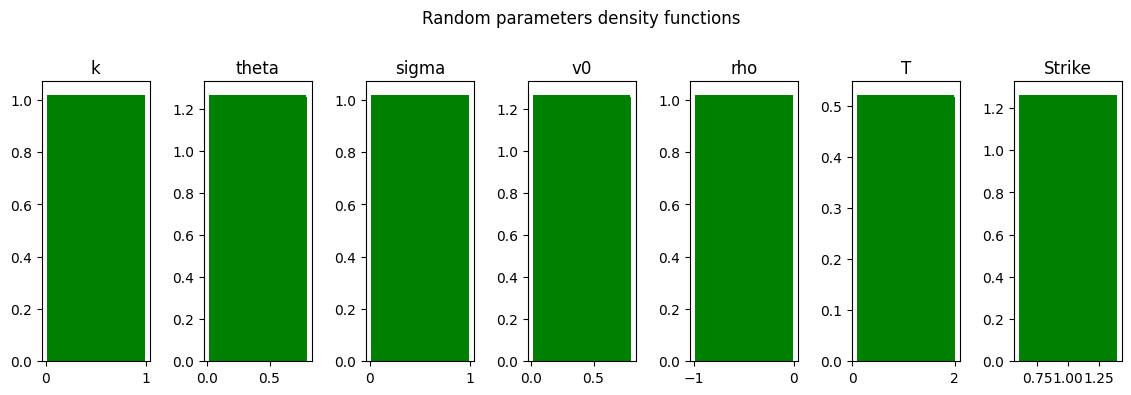

In [19]:
__tStart= time.perf_counter()
kw, x = lhs_sampling(rand, NUM, bounds = bounds)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("LHS", __tEnd - __tStart) )
    
# Let's check the distribution of the parameters we have generated
histo_array(list(kw), x, title = "Random parameters density functions") 

In [22]:
# strikes used to build the smile used as a feature (regressor)
strikes = np.arange(.8, 1.2, .025)

In [48]:
# Generate training/test set
__tStart=time.perf_counter()
df =  mkt_gen( pars = x, kw = kw, Xc=XC, strikes = strikes)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd-__tStart) )

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [26:29<00:00,  6.29it/s]

@ Seq. pricing                      : elapsed 1589.7735 sec
@ Info                              : Violations Put=3, Call=0 DB=9997 out of 10000
@ GEN                               : elapsed 1589.7785 sec


**Generate training/test set**

In [19]:
outputFile = 'C:/data/mkt_gen_out_heston_2_3.csv'
df.to_csv(outputFile, sep=';', float_format="%.6f", index=False)
print("@ %-34s: mkt generated data frame written to '%s'" %("Info", outputFile))

@ Info                              : mkt generated data frame written to 'C:/data/mkt_gen_out_heston_2_3.csv'


In [23]:
inputFile = 'C:/data/mkt_gen_out_heston_2_3.csv'
df = pd.read_csv(inputFile, sep=';')
print("@ %-34s: mkt generated data frame read from '%s'" %("Info", inputFile))

@ Info                              : mkt generated data frame read from 'C:/data/mkt_gen_out_heston_2_3.csv'


**Select and display a subset of the generated smiles...**

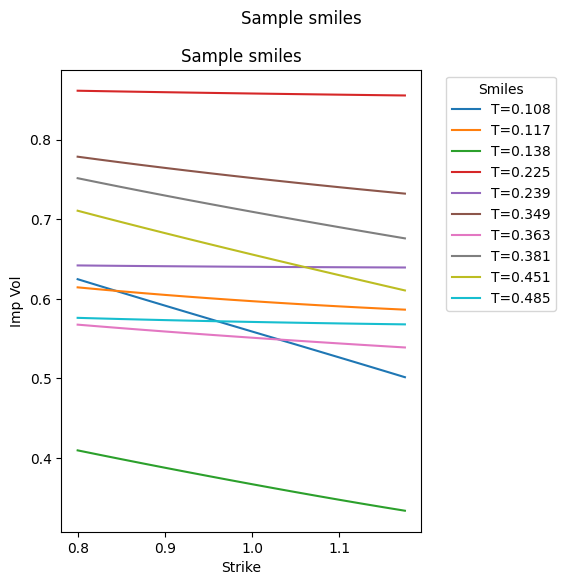

In [24]:
# displays a subset of the generated smiles ....
smiles = smiles_select(strikes, df, NUMSMILES=10)
show_smiles( smiles=smiles)

In [25]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import time

def mkt_gen_surface(pars=None, Xc=10, strikes=None, maturities=None):
    """
    Generate a synthetic dataset of implied volatility surfaces using the Heston model.
    For each set of Heston parameters, a full surface over (strike, maturity) is generated.

    Parameters:
    -----------
    pars : np.ndarray
        Array of shape (N, 5), each row is [kappa, theta, sigma, v0, rho].
    Xc : float
        Numerical integration cutoff for Heston Fourier pricing.
    strikes : list or np.ndarray
        Array of strike prices.
    maturities : list or np.ndarray
        Array of time to maturities.

    Returns:
    --------
    df : pd.DataFrame
        A DataFrame where each row corresponds to a (K, T) point for a given parameter set,
        with columns: ParamIndex, Kappa, Theta, Sigma, v0, Rho, T, K, and IV.
    """

    if pars is None or strikes is None or maturities is None:
        raise ValueError("Missing required inputs: pars, strikes, maturities.")

    rows = []
    Fw = 1.0  # Fixed forward price

    __tStart = time.perf_counter()

    for idx, p in enumerate(tqdm(pars)):
        Kappa, Theta, Sigma, v0, Rho = p[:5]

        for T in maturities:
            # Build full smile at this maturity
            vol_dict = build_smile(strikes=strikes, Fw=Fw, T=T,
                                   Kappa=Kappa, Theta=Theta,
                                   sgma=Sigma, Ro=v0, Rho=Rho, Xc=Xc)
            if vol_dict is None:
                continue  # skip if pricing failed

            for K in strikes:
                tag = "k=%5.3f" % K
                iv = vol_dict.get(tag, np.nan)

                rows.append({
                    "ParamIndex": idx,
                    "Kappa": Kappa,
                    "Theta": Theta,
                    "Sigma": Sigma,
                    "v0": v0,
                    "Rho": Rho,
                    "T": T,
                    "K": K,
                    "IV": iv
                })

    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" % ("Surface pricing", __tEnd - __tStart))

    return pd.DataFrame(rows)

In [26]:
# 10 maturities from 1 month (0.08) to 2 years (2.0), in years
maturities = np.linspace(0.08, 2.0, 10)

In [27]:
df_surf = mkt_gen_surface(pars=x[:100,:], strikes=strikes, maturities=maturities)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]

@ Surface pricing                   : elapsed 181.4598 sec


In [28]:
df_surf.head()

,ParamIndex,Kappa,Theta,Sigma,v0,Rho,T,K,IV
0,0,0.448026,0.016597,0.447036,0.20675,-0.030442,0.08,0.800,0.455430
1,0,0.448026,0.016597,0.447036,0.20675,-0.030442,0.08,0.825,0.454137
2,0,0.448026,0.016597,0.447036,0.20675,-0.030442,0.08,0.850,0.453014
3,0,0.448026,0.016597,0.447036,0.20675,-0.030442,0.08,0.875,0.452055
4,0,0.448026,0.016597,0.447036,0.20675,-0.030442,0.08,0.900,0.451252


In [29]:
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(df, param_index):
    """
    Plot a 3D implied volatility surface for a given parameter index from the long-format DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame produced by `mkt_gen_surface`, with columns: ParamIndex, K, T, IV, etc.
    param_index : int
        The integer index identifying the Heston parameter set (as stored in the 'ParamIndex' column).

    Returns:
    --------
    None (displays a 3D matplotlib surface plot)
    """

    # Filter the DataFrame for the specified parameter vector
    sub_df = df[df["ParamIndex"] == param_index]

    if sub_df.empty:
        print(f"⚠️ No data found for ParamIndex = {param_index}")
        return

    # Pivot into a 2D matrix: rows = strikes, cols = maturities
    pivot = sub_df.pivot_table(index="K", columns="T", values="IV")
    strikes = pivot.index.values
    maturities = pivot.columns.values
    surface = pivot.values

    # Prepare grid for 3D plotting
    T_grid, K_grid = np.meshgrid(maturities, strikes)

    # Plot
    fig = plt.figure(figsize=(5, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T_grid, K_grid, surface, cmap="viridis", edgecolor="k", alpha=0.9)

    ax.set_xlabel("Maturity (T)")
    ax.set_ylabel("Strike (K)")
    ax.set_zlabel("Implied Volatility")
    ax.set_title(f"IV Surface for ParamIndex = {param_index}")

    plt.tight_layout()
    plt.show()

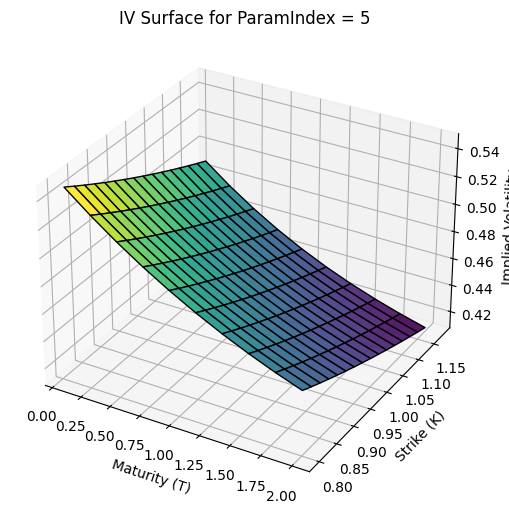

In [31]:
plot_iv_surface(df_surf, param_index=5)

**Selects a random subset as test set**

In [32]:
Xv, Y = train_test_split(df, test_size=0.33, random_state=rand.randint(42))

**Generate some noise for the training set**

In [33]:
EPS = 0.0
if EPS > 0.0:
    X = Xv.copy()
    xl = np.min(X["Price"])
    xh = np.max(X["Price"])

    xi = rand.normal( loc = 0.0, scale = EPS*(xh-xl), size=X.shape[0])
    X["Price"] += xi
else: X = Xv

**Display the amount of noise**

In [34]:
import warnings
warnings.simplefilter('ignore')

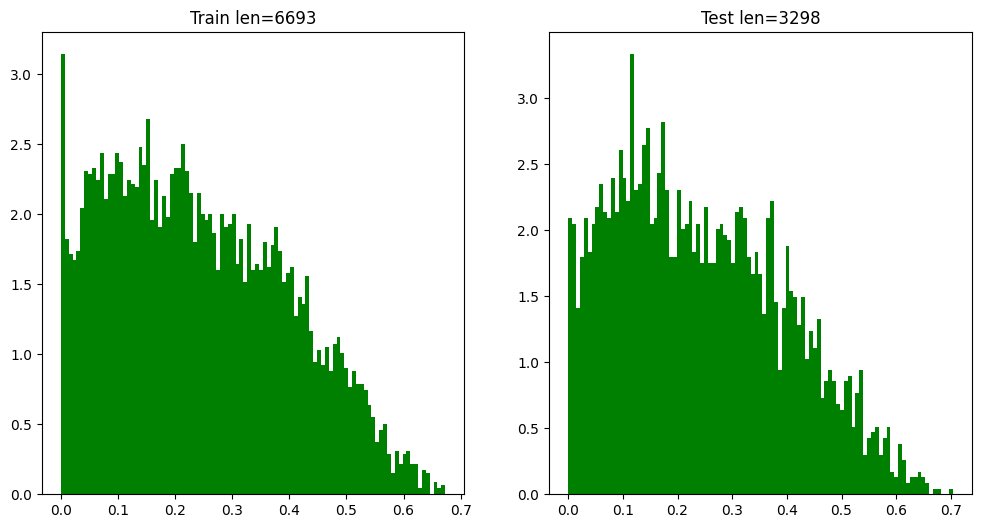

In [35]:
if EPS > 0.0:
    xMin = 0.0
    xMax = max(Xv["Price"])
    v = np.arange(xMin, xMax, (xMax - xMin)/100.)

    fig, ax = plt.subplots(1,1, figsize=(12,6))

    ax.plot( Xv["Price"], X["Price"], ".", markersize=1)
    ax.plot( v, v, color="red")
    ax.set_title("Perturbed")
    ax.set_xlabel("Xv")
    ax.set_ylabel("X")

    figName = "scatter_%s.png" %(TAG)
    plt.savefig(figName, format="png")        

    plt.show()
                
    histo_dict( {"Train": np.array(Xv["Price"]), 
                 "Test": np.array(Y["Price"]), 
                 "Perturbed": np.array(X["Price"]) } , TAG=TAG )
else:
    histo_dict( {"Train": np.array(Xv["Price"]), 
                 "Test": np.array(Y["Price"]) }, TAG=TAG )


**Remove target from challenge set**

In [36]:
t = pd.DataFrame({"Price": Y["Price"]})
y = Y.drop(columns="Price") 

## Saving Result to Disk

**Write training set to disk**

In [37]:
outputFile = "%s_%s.csv" %(outputPrfx, TAG)
outputFile = 'C:/data/' + outputFile
X.to_csv(outputFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: training data frame written to '%s'" %("Info", outputFile))
if verbose: print(outputFile); print(X)

@ Info                              : training data frame written to 'C:/data/full_10000_VFA.csv'


In [38]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(outputFile)    

**Write challenge set to disk**

In [39]:
challengeFile = "%s_%s.csv" %(challengePrfx, TAG)
challengeFile = 'C:/data/' + challengeFile
y.to_csv(challengeFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: challenge data frame written to '%s'" %("Info", challengeFile))
if verbose: print(challengeFile); print(y)

@ Info                              : challenge data frame written to 'C:/data/test_10000_VFA.csv'


In [40]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(challengeFile)    

**Write target array do disk**

In [41]:
    targetFile = "%s_%s.csv" %(targetPrfx, TAG)
    targetFile = 'C:/data/' + targetFile
    t.to_csv(targetFile, sep=',', float_format="%.6f", index=False)
    print("@ %-34s: target data frame written to '%s'" %("Info", targetFile))
    if verbose: print(targetFile); print(t)

@ Info                              : target data frame written to 'C:/data/trgt_10000_VFA.csv'


In [42]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(targetFile)    